# Power consumption forecasting using ARIMA with Fourier errors

- Without model re-estimation
- without median_residuals

In [1]:
library(readr)
library(dplyr)
library(ggplot2)
library(gridExtra)
library(xts)
library(fpp2)
library(DMwR)
library(Metrics)
library(tseries)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last

Loading required package: forecast
Loading required package: fma
Loading required package: expsmooth
Loading required package: lattice
Loading required package: grid

Attaching package: ‘DMwR’

The following object is masked from ‘package:fma’:

    sales


Attaching package: ‘Metrics’

The following object is masked from ‘package:forecast’:

    accuracy



In [2]:
options(repr.plot.width=8, repr.plot.height=4)

## 1. Data import

In [3]:
path <- '../data/power-consumption/processed_data.csv'
data <- read_csv(path)

Parsed with column specification:
cols(
  date = col_date(format = ""),
  Global_active_power = col_double(),
  Global_reactive_power = col_double(),
  Voltage = col_double(),
  Global_intensity = col_double(),
  Sub_metering_1 = col_double(),
  Sub_metering_2 = col_double(),
  Sub_metering_3 = col_double(),
  Sub_metering_4 = col_double(),
  Month = col_double(),
  Weekday = col_double(),
  WeekOfYear = col_double(),
  Median_active_power = col_double(),
  Lagged_active_power = col_double(),
  median_residual = col_double()
)


In [4]:
# discard selected columns
data <- select(data, Global_active_power)

In [5]:
head(data)
tail(data)
nrow(data)

Global_active_power
1209.176
3390.460
2203.826
1666.194
2225.748
1723.288


Global_active_power
900.910
2041.536
1577.536
1796.248
1431.164
1488.104


[1] 1442

## 2. Convert to ts object

In [6]:
# define date range as per the data
date_range <- seq(as.Date('2006-12-16'), as.Date('2010-11-26'), by='day')

# no need to put the date column as it will generate as ts index
dayofyear <- as.numeric(format(date_range[1], '%j'))

power_data <- ts(data, start=c(2006, dayofyear), frequency = 365)

In [7]:
head(power_data)

Time Series:
Start = c(2006, 350) 
End = c(2006, 355) 
Frequency = 365 
     Global_active_power
[1,]            1209.176
[2,]            3390.460
[3,]            2203.826
[4,]            1666.194
[5,]            2225.748
[6,]            1723.288

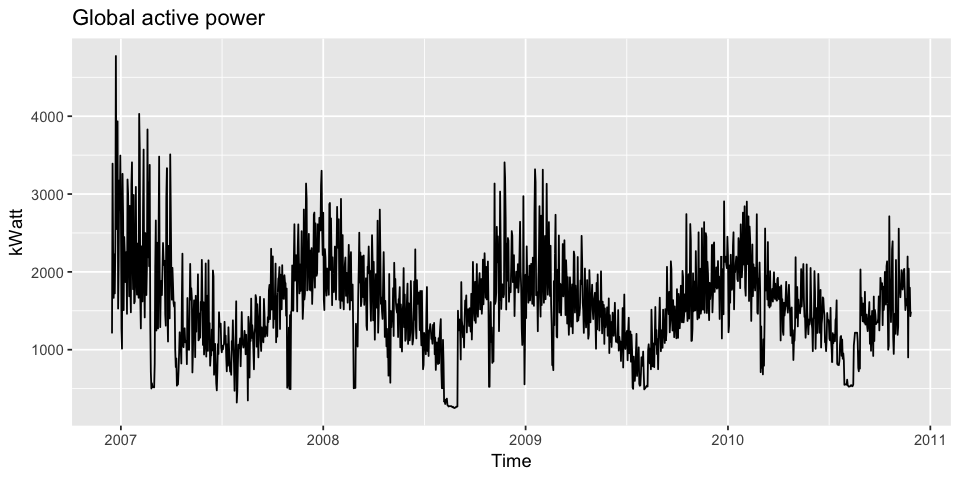

In [8]:
autoplot(power_data) +
    ggtitle('Global active power') +
    ylab('kWatt')

## 3. Train test split

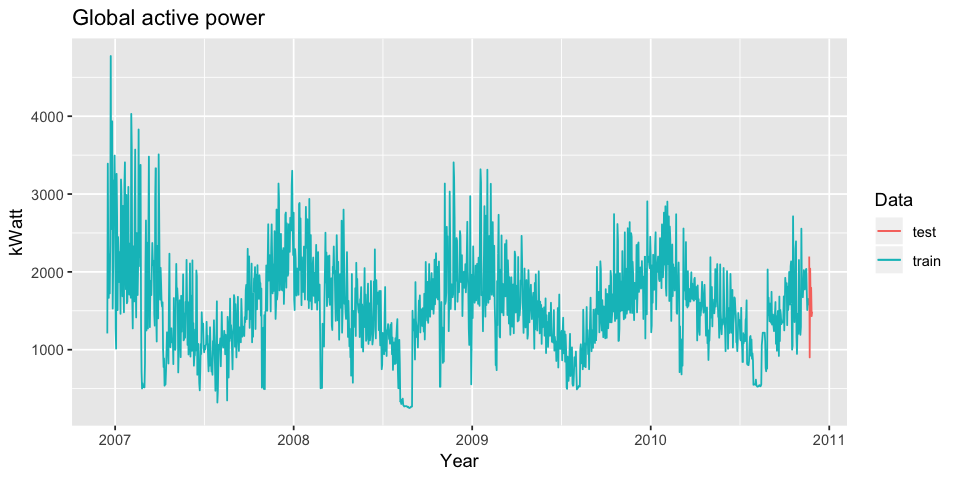

In [9]:
# train and test split
# last two weeks will be test set rest training set
# we will drop the explanatory  variables for baseline models
# as they will not be need for forecasting

test_size <- as.numeric(7*1)
train_size <- nrow(power_data)- test_size

train <- head(power_data, train_size)
test <- tail(power_data, test_size)

autoplot(train, series = 'train') + 
    autolayer(test, series = 'test') +
    ggtitle('Global active power') +
    ylab('kWatt') + 
    xlab('Year') +
    guides(colour=guide_legend(title="Data"))

In [10]:
head(train)

Time Series:
Start = c(2006, 350) 
End = c(2006, 355) 
Frequency = 365 
     Global_active_power
[1,]            1209.176
[2,]            3390.460
[3,]            2203.826
[4,]            1666.194
[5,]            2225.748
[6,]            1723.288

## 4. Model fitting (without re-estimation)

In [11]:
# multi-step forecasting using SARIMAX
# use arima order determined in previous step
multistep_forecasting <- function(train, test, h=7){
                            fit <- Arima(train, order = c(2, 1, 2), seasonal = c(0, 1, 0), 
                                         xreg = fourier(train, K=1), lambda = NULL)
                            saveRDS(fit, '../checkpoints/power/R-models/fourier-v1.rds')
#                             fit <- readRDS('../checkpoints/power/R-models/fourier-v1.rds')

                            train_pred <- fitted(fit)
                            
                            n <- length(test)
                            test_pred <- ts(numeric(n), start=c(2010, 318), freq=365)
    
                            test_exog <- fourier(test, K=1)
                            test_pred <- forecast(fit, h=h, xreg=test_exog)$mean
                            
                            output <- list(train=train_pred, test=test_pred, model=fit)
                            return(output) 
                            }

In [11]:
fit <- Arima(train, order = c(2, 1, 2), seasonal = c(0, 1, 0), 
             xreg = fourier(train, K=1), lambda = NULL)
saveRDS(fit, '../checkpoints/power/R-models/fourier-v1.rds')
# fit <- readRDS('../checkpoints/power/R-models/fourier-v1.rds')

ERROR: Error in solve.default(res$hessian * n.used, A): system is computationally singular: reciprocal condition number = 1.33924e-45


In [ ]:
train_pred <- fitted(fit)

n <- length(test)
test_pred <- ts(numeric(n), start=c(2010, 318), freq=365)

test_exog <- fourier(test, K=1)
test_pred <- forecast(fit, h=h, xreg=test_exog)$mean

output <- list(train=train_pred, test=test_pred, model=fit)

In [ ]:
result = multistep_forecasting(train, test, h=7) 
result$test
test

## 5. Model evaluation

In [ ]:
autoplot(train, series = 'train actual') +
    autolayer(result$train, series = 'train prediction') +
    xlab('Year') +
    ylab('kWatt') +
    ggtitle('SARIMAX method forecasting')

In [ ]:
autoplot(test, series = 'test') +
    autolayer(result$test, series = 'test prediction') +
    xlab('Year') +
    ylab('kWatt') +
    ggtitle('SARIMAX method forecasting')

In [ ]:
p1 <- autoplot(result$test, series='predicted') + ggtitle('Prediction')
p2 <- autoplot(test, series = 'actual') + ggtitle('Actual data')

gridExtra::grid.arrange(p1, p2, ncol=1)

In [ ]:
train_pred <- result$train
test_pred <- result$test

train_rmse <- sqrt(mse(train, train_pred))
train_mae <- mae(train, train_pred)
train_nrmse <- train_rmse/sd(train)

test_rmse <- sqrt(mse(test, test_pred))
test_mae <- mae(test, test_pred)
test_nrmse <- test_rmse/sd(test)

# print(paste0('Training RMSE :', round(train_rmse, 3)))
print(paste0('Training NRMSE :', round(train_nrmse, 3)))
print(paste0('Training MAE :', round(train_mae, 3)))

# print(paste0('Test RMSE :', round(test_rmse, 3)))
print(paste0('Test NRMSE :', round(test_nrmse, 3)))
print(paste0('Test MAE :', round(test_mae, 3)))

## 6. Residual and co-efficient analysis

In [ ]:
summary(result$model)
checkresiduals(result$model)